In [0]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
from torch import nn
from torchvision import datasets, transforms                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Vnet(propsesd architecture) for different datasets and comparision with existing models

# MNIST

In [0]:
transform = transforms.Compose([transforms.Resize((28,28)),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5,), (0.5,))
                               ])
training_dataset = datasets.MNIST(root='./data1', train=True, download=True, transform=transform)
validation_dataset = datasets.MNIST(root='./data2', train=False, download=True, transform=transform)

training_loader = torch.utils.data.DataLoader(training_dataset, batch_size=100, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size = 100, shuffle=False)

0it [00:00, ?it/s]

9920512it [00:03, 3298715.67it/s]                            


Extracting ./data1/MNIST/raw/train-images-idx3-ubyte.gz


0it [00:00, ?it/s]

32768it [00:00, 47679.79it/s]                           
0it [00:00, ?it/s]

Extracting ./data1/MNIST/raw/train-labels-idx1-ubyte.gz


1654784it [00:02, 798804.80it/s]                             
0it [00:00, ?it/s]

Extracting ./data1/MNIST/raw/t10k-images-idx3-ubyte.gz


8192it [00:00, 18030.55it/s]            
0it [00:00, ?it/s]

Extracting ./data1/MNIST/raw/t10k-labels-idx1-ubyte.gz
Processing...
Done!


9920512it [00:03, 3306507.02it/s]                             


Extracting ./data2/MNIST/raw/train-images-idx3-ubyte.gz


0it [00:00, ?it/s]

32768it [00:00, 47937.36it/s]                           
0it [00:00, ?it/s]

Extracting ./data2/MNIST/raw/train-labels-idx1-ubyte.gz


1654784it [00:02, 788925.37it/s]                             
0it [00:00, ?it/s]

Extracting ./data2/MNIST/raw/t10k-images-idx3-ubyte.gz


8192it [00:00, 17893.87it/s]            

Extracting ./data2/MNIST/raw/t10k-labels-idx1-ubyte.gz
Processing...
Done!


In [0]:
def im_convert(tensor):
  image = tensor.cpu().clone().detach().numpy()
  image = image.transpose(1, 2, 0)
  image = image * np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5))
  image = image.clip(0, 1)
  return image

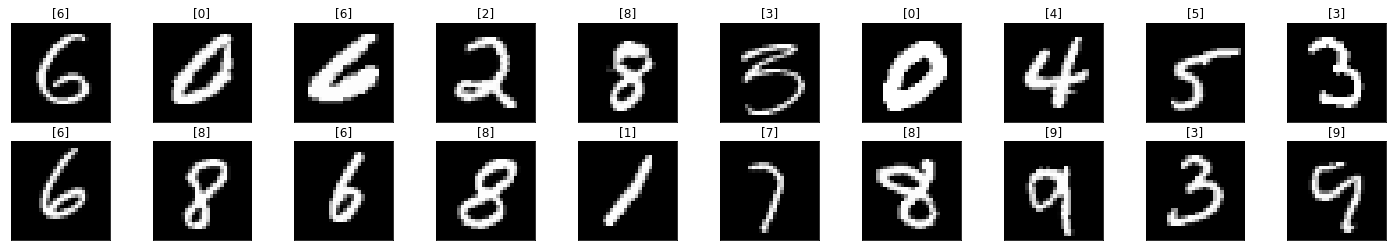

In [0]:
dataiter = iter(training_loader)
images, labels = dataiter.next()
fig = plt.figure(figsize=(25, 4))

for idx in np.arange(20):
  ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
  plt.imshow(im_convert(images[idx]))
  ax.set_title([labels[idx].item()])

## VNet For MNIST digit classfication

In [0]:
# m= nn.Conv2d(20, 50, 5, 1)
# input = torch.randn(1, 20, 24, 24)
# output = m(input)
# output.shape
# # torch.Size([20, 20, 24, 24])

torch.Size([1, 50, 20, 20])

In [0]:
class VNet(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv_X1 = nn.Conv2d(1,20,5,1)
    self.conv_X2 = nn.Conv2d(20,30,5,1)
    self.conv_X3 = nn.Conv2d(30,40,4,1)
    
    self.conv_Y1 = nn.Conv2d(1,20,5,1)
    self.conv_Y2 = nn.Conv2d(20,30,5,1)
    self.conv_Y3 = nn.Conv2d(30,40,4,1)
    
    self.conv_Z1 = nn.Conv2d(1,20,5,1)
    self.conv_Z2 = nn.Conv2d(20,30,5,1)
    self.conv_Z3 = nn.Conv2d(30,40,4,1)
    
    self.conv_Xinter = nn.Conv2d(20,30,5,1)
    self.conv_Yinter = nn.Conv2d(30,40,4,1)
    self.conv_Zinter = nn.Conv2d(40,50,1,1)
    
    self.fc1=nn.Linear(480,500)
    self.fc2=nn.Linear(40,100)
    self.fc3=nn.Linear(50,100)
    self.dropout1 = nn.Dropout(0.5)
    self.fc = nn.Linear(700, 10)

  def forward(self,x):
    si=x.size(0)
    x1 = F.relu(self.conv_X1(x))
    x1 = F.max_pool2d(x1,2,2)
    xinter =x1
    
    x1 = F.relu(self.conv_X2(x1))
    x1 = F.max_pool2d(x1,2,2)
    x1 = F.relu(self.conv_X3(x1))
    x1 = F.max_pool2d(x1,2,2)
    
    x2 = F.relu(self.conv_Y1(x))
    x2 = F.max_pool2d(x2,2,2)
    x2 = F.relu(self.conv_Y2(x2))
    x2 = F.max_pool2d(x2,2,2)
    yinter = x2
    x2 = F.relu(self.conv_Y3(x2))
    x2= F.max_pool2d(x2,2,2)
    
    x3 = F.relu(self.conv_Z1(x))
    x3 = F.max_pool2d(x3,2,2)
    x3 = F.relu(self.conv_Z2(x3))
    x3 = F.max_pool2d(x3,2,2)
    x3 = F.relu(self.conv_Z3(x3))
    x3 = F.max_pool2d(x3,2,2)
    zinter=x3
    
    xinter = F.relu(self.conv_Xinter(xinter))
    xinter = F.max_pool2d(xinter,2,2)
    yinter = F.relu(self.conv_Yinter(yinter))
    yinter = F.max_pool2d(yinter,2,2)
    zinter = F.relu(self.conv_Zinter(zinter))
    zinter = F.max_pool2d(zinter,2,2)
    
    xinter = xinter.view(si,-1)
    xinter = F.relu(self.fc1(xinter))
    xinter = self.dropout1(xinter)
    
    yinter = yinter.view(si,-1)
    yinter = F.relu(self.fc2(yinter))
    yinter = self.dropout1(yinter)
    
    zinter = zinter.view(si,-1)
    zinter = F.relu(self.fc3(zinter))
    zinter = self.dropout1(zinter)
    
    flatten=torch.cat((xinter,yinter,zinter),dim=1)
#     flatten=torch.cat((flatten,zinter),dim=1)
    
    return self.fc(flatten)
    
    
    
model=VNet().to(device)
model
    
    
    

VNet(
  (conv_X1): Conv2d(1, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv_X2): Conv2d(20, 30, kernel_size=(5, 5), stride=(1, 1))
  (conv_X3): Conv2d(30, 40, kernel_size=(4, 4), stride=(1, 1))
  (conv_Y1): Conv2d(1, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv_Y2): Conv2d(20, 30, kernel_size=(5, 5), stride=(1, 1))
  (conv_Y3): Conv2d(30, 40, kernel_size=(4, 4), stride=(1, 1))
  (conv_Z1): Conv2d(1, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv_Z2): Conv2d(20, 30, kernel_size=(5, 5), stride=(1, 1))
  (conv_Z3): Conv2d(30, 40, kernel_size=(4, 4), stride=(1, 1))
  (conv_Xinter): Conv2d(20, 30, kernel_size=(5, 5), stride=(1, 1))
  (conv_Yinter): Conv2d(30, 40, kernel_size=(4, 4), stride=(1, 1))
  (conv_Zinter): Conv2d(40, 50, kernel_size=(1, 1), stride=(1, 1))
  (fc1): Linear(in_features=480, out_features=500, bias=True)
  (fc2): Linear(in_features=40, out_features=100, bias=True)
  (fc3): Linear(in_features=50, out_features=100, bias=True)
  (dropout1): Dropout(p=0.5)
  (fc): Linear(i

## VNet Version2

In [0]:
class VNetModified(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv_X1 = nn.Conv2d(1,20,5,1)
    self.conv_X2 = nn.Conv2d(20,30,5,1)
    self.conv_X3 = nn.Conv2d(30,40,4,1)
    
    self.conv_Y1 = nn.Conv2d(1,20,5,1)
    self.conv_Y2 = nn.Conv2d(20,30,5,1)
    self.conv_Y3 = nn.Conv2d(30,40,4,1)
    
    self.conv_Z1 = nn.Conv2d(1,20,5,1)
    self.conv_Z2 = nn.Conv2d(20,30,5,1)
    self.conv_Z3 = nn.Conv2d(30,40,4,1)
    
    self.conv_Xinter = nn.Conv2d(20,30,5,1)
    self.conv_Yinter = nn.Conv2d(30,40,4,1)
    self.conv_Zinter = nn.Conv2d(40,50,1,1)
    
    self.fc_Xinter=nn.Linear(480,500)
    self.fc_Yinter=nn.Linear(40,100)
    self.fc_Zinter=nn.Linear(50,100)
    
    self.fc_Xend=nn.Linear(40,100)
    self.fc_Yend=nn.Linear(40,100)
    self.fc_Zend =nn.Linear(40,100)
    
    self.dropout_Xinter = nn.Dropout(0.5)
    self.dropout_Yinter = nn.Dropout(0.5)
    self.dropout_Zinter = nn.Dropout(0.5)
     
    self.dropout_Xend = nn.Dropout(0.5)
    self.dropout_Yend = nn.Dropout(0.5)
    self.dropout_Zend = nn.Dropout(0.5)
    
#     self.dropout1 =nn.Dropout(0.5)
#     self.dropout2 =nn.Dropout(0.5)
    
    self.fc1 = nn.Linear(1000, 10)
#     self.fc2 = nn.Linear(784, 256)
#     self.fc3 = nn.Linear(256,10)
    
#     self.finalfc=nn.Linear(784,256)
   

  def forward(self,x):
    si=x.size(0)
    x1 = F.relu(self.conv_X1(x))
    x1 = F.max_pool2d(x1,2,2)
    xinter =x1
    
    x1 = F.relu(self.conv_X2(x1))
    x1 = F.max_pool2d(x1,2,2)
    x1 = F.relu(self.conv_X3(x1))
    x1 = F.max_pool2d(x1,2,2)
    
    x2 = F.relu(self.conv_Y1(x))
    x2 = F.max_pool2d(x2,2,2)
    x2 = F.relu(self.conv_Y2(x2))
    x2 = F.max_pool2d(x2,2,2)
    yinter = x2
    x2 = F.relu(self.conv_Y3(x2))
    x2= F.max_pool2d(x2,2,2)
    
    x3 = F.relu(self.conv_Z1(x))
    x3 = F.max_pool2d(x3,2,2)
    x3 = F.relu(self.conv_Z2(x3))
    x3 = F.max_pool2d(x3,2,2)
    x3 = F.relu(self.conv_Z3(x3))
    x3 = F.max_pool2d(x3,2,2)
    zinter=x3
    
    xinter = F.relu(self.conv_Xinter(xinter))
    xinter = F.max_pool2d(xinter,2,2)
    yinter = F.relu(self.conv_Yinter(yinter))
    yinter = F.max_pool2d(yinter,2,2)
    zinter = F.relu(self.conv_Zinter(zinter))
    zinter = F.max_pool2d(zinter,2,2)
    
    xinter = xinter.view(si,-1)
    xinter = F.relu(self.fc_Xinter(xinter))
    xinter = self.dropout_Xinter(xinter)
    
    yinter = yinter.view(si,-1)
    yinter = F.relu(self.fc_Yinter(yinter))
    yinter = self.dropout_Yinter(yinter)
    
    zinter = zinter.view(si,-1)
    zinter = F.relu(self.fc_Zinter(zinter))
    zinter = self.dropout_Zinter(zinter)
    
    
    X_end = x1.view(si,-1)
    X_end = F.relu(self.fc_Xend(X_end))
    X_end = self.dropout_Xend(X_end)
    
     
    Y_end = x2.view(si,-1)
    Y_end = F.relu(self.fc_Yend(Y_end))
    Y_end = self.dropout_Yend(Y_end)
     
    Z_end = x3.view(si,-1)
    Z_end = F.relu(self.fc_Zend(Z_end))
    Z_end = self.dropout_Zend(Z_end)
    
    flatten=torch.cat((X_end,Y_end,Z_end,xinter,yinter,zinter),dim=1)
#     flatten=torch.cat((flatten,zinter),dim=1)
#     flatten = F.relu(self.fc1(flatten))
#     flatten = self.dropout1(flatten)
#     flatten  = F.relu(self.fc2(flatten))
#     flatten = self.dropout2(flatten)
    
    return self.fc1(flatten)
    
    
    

model = VNetModified().to(device)
model    

VNetModified(
  (conv_X1): Conv2d(1, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv_X2): Conv2d(20, 30, kernel_size=(5, 5), stride=(1, 1))
  (conv_X3): Conv2d(30, 40, kernel_size=(4, 4), stride=(1, 1))
  (conv_Y1): Conv2d(1, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv_Y2): Conv2d(20, 30, kernel_size=(5, 5), stride=(1, 1))
  (conv_Y3): Conv2d(30, 40, kernel_size=(4, 4), stride=(1, 1))
  (conv_Z1): Conv2d(1, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv_Z2): Conv2d(20, 30, kernel_size=(5, 5), stride=(1, 1))
  (conv_Z3): Conv2d(30, 40, kernel_size=(4, 4), stride=(1, 1))
  (conv_Xinter): Conv2d(20, 30, kernel_size=(5, 5), stride=(1, 1))
  (conv_Yinter): Conv2d(30, 40, kernel_size=(4, 4), stride=(1, 1))
  (conv_Zinter): Conv2d(40, 50, kernel_size=(1, 1), stride=(1, 1))
  (fc_Xinter): Linear(in_features=480, out_features=500, bias=True)
  (fc_Yinter): Linear(in_features=40, out_features=100, bias=True)
  (fc_Zinter): Linear(in_features=50, out_features=100, bias=True)
  (fc_Xend): Linear

In [0]:
# image = torch.randn(2, 1, 28, 28).to(device)
# model(image)

## RUN model

In [0]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001)
epochs = 20
running_loss_history = []
running_corrects_history = []
val_running_loss_history = []
val_running_corrects_history = []



for e in range(epochs):
  
  running_loss = 0.0
  running_corrects = 0.0
  val_running_loss = 0.0
  val_running_corrects = 0.0
  print(e)
  for inputs, labels in training_loader:
    inputs = inputs.to(device)
    labels = labels.to(device)
    outputs = model(inputs)
    loss = criterion(outputs, labels)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    _, preds = torch.max(outputs, 1)
    running_loss += loss.item()
    running_corrects += torch.sum(preds == labels.data)

  else:
    with torch.no_grad():
      for val_inputs, val_labels in validation_loader:
        val_inputs = val_inputs.to(device)
        val_labels = val_labels.to(device)
        val_outputs = model(val_inputs)
        val_loss = criterion(val_outputs, val_labels)
        
        _, val_preds = torch.max(val_outputs, 1)
        val_running_loss += val_loss.item()
        val_running_corrects += torch.sum(val_preds == val_labels.data)
    epoch_loss = running_loss/len(training_loader)
    epoch_acc = running_corrects.float()/ len(training_loader)
    running_loss_history.append(epoch_loss)
    running_corrects_history.append(epoch_acc)
    
    val_epoch_loss = val_running_loss/len(validation_loader)
    val_epoch_acc = val_running_corrects.float()/ len(validation_loader)
    val_running_loss_history.append(val_epoch_loss)
    val_running_corrects_history.append(val_epoch_acc)
    print('epoch :', (e+1))
    print('training loss: {:.4f}, acc {:.4f} '.format(epoch_loss, epoch_acc.item()))
    print('validation loss: {:.4f}, validation acc {:.4f} '.format(val_epoch_loss, val_epoch_acc.item()))

0
epoch : 1
training loss: 0.5942, acc 84.4967 
validation loss: 0.1703, validation acc 95.1600 
1
epoch : 2
training loss: 0.1385, acc 95.9367 
validation loss: 0.0989, validation acc 96.9900 
2
epoch : 3
training loss: 0.0923, acc 97.2050 
validation loss: 0.0694, validation acc 97.8400 
3
epoch : 4
training loss: 0.0719, acc 97.9167 
validation loss: 0.0585, validation acc 98.2900 
4
epoch : 5
training loss: 0.0591, acc 98.2283 
validation loss: 0.0489, validation acc 98.4800 
5
epoch : 6
training loss: 0.0513, acc 98.4700 
validation loss: 0.0424, validation acc 98.7500 
6
epoch : 7
training loss: 0.0438, acc 98.6867 
validation loss: 0.0374, validation acc 98.7600 
7
epoch : 8
training loss: 0.0390, acc 98.8317 
validation loss: 0.0382, validation acc 98.7800 
8
epoch : 9
training loss: 0.0356, acc 98.9167 
validation loss: 0.0322, validation acc 98.9500 
9
epoch : 10
training loss: 0.0312, acc 99.0200 
validation loss: 0.0333, validation acc 98.9200 
10
epoch : 11
training loss: 

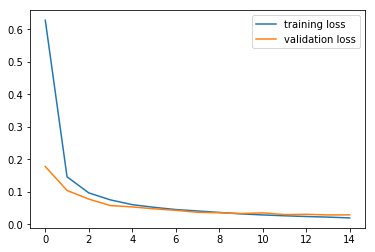

In [0]:
plt.plot(running_loss_history, label='training loss')
plt.plot(val_running_loss_history, label='validation loss')
plt.legend()

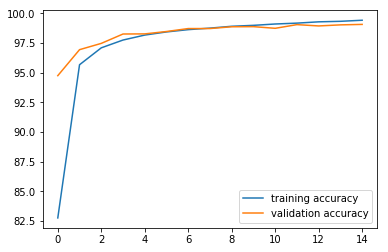

In [0]:

plt.plot(running_corrects_history, label='training accuracy')
plt.plot(val_running_corrects_history, label='validation accuracy')
plt.legend()

# CIFAR-10

In [0]:
transform_train = transforms.Compose([transforms.Resize((32,32)),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.RandomRotation(10),
                                      transforms.RandomAffine(0, shear=10, scale=(0.8,1.2)),
                                      transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                               ])


transform = transforms.Compose([transforms.Resize((32,32)),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                               ])
training_dataset = datasets.CIFAR10(root='./d', train=True, download=True, transform=transform_train)
validation_dataset = datasets.CIFAR10(root='./dq', train=False, download=True, transform=transform)

training_loader = torch.utils.data.DataLoader(training_dataset, batch_size=100, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size = 100, shuffle=False)

0it [00:00, ?it/s]

100%|█████████▉| 169730048/170498071 [00:10<00:00, 20896489.02it/s]
0it [00:00, ?it/s]


 99%|█████████▉| 168894464/170498071 [00:09<00:00, 20217801.41it/s]

In [0]:
def fit(model):
  criterion = nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001)
  epochs = 50
  running_loss_history = []
  running_corrects_history = []
  val_running_loss_history = []
  val_running_corrects_history = []



  for e in range(epochs):
  
    running_loss = 0.0
    running_corrects = 0.0
    val_running_loss = 0.0
    val_running_corrects = 0.0
    print(e)
    for inputs, labels in training_loader:
      inputs = inputs.to(device)
      labels = labels.to(device)
      outputs = model(inputs)
      loss = criterion(outputs, labels)
    
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
    
      _, preds = torch.max(outputs, 1)
      running_loss += loss.item()
      running_corrects += torch.sum(preds == labels.data)

    else:
      with torch.no_grad():
        for val_inputs, val_labels in validation_loader:
          val_inputs = val_inputs.to(device)
          val_labels = val_labels.to(device)
          val_outputs = model(val_inputs)
          val_loss = criterion(val_outputs, val_labels)
        
          _, val_preds = torch.max(val_outputs, 1)
          val_running_loss += val_loss.item()
          val_running_corrects += torch.sum(val_preds == val_labels.data)
      epoch_loss = running_loss/len(training_loader)
      epoch_acc = running_corrects.float()/ len(training_loader)
      running_loss_history.append(epoch_loss)
      running_corrects_history.append(epoch_acc)
    
      val_epoch_loss = val_running_loss/len(validation_loader)
      val_epoch_acc = val_running_corrects.float()/ len(validation_loader)
      val_running_loss_history.append(val_epoch_loss)
      val_running_corrects_history.append(val_epoch_acc)
      print('epoch :', (e+1))
      print('training loss: {:.4f}, acc {:.4f} '.format(epoch_loss, epoch_acc.item()))
      print('validation loss: {:.4f}, validation acc {:.4f} '.format(val_epoch_loss, val_epoch_acc.item()))


170500096it [00:26, 20217801.41it/s]                               

## LNET 

In [0]:
class LeNet(nn.Module):
    def __init__(self):
      super().__init__()
      self.conv1 = nn.Conv2d(3, 16, 3, 1, padding=1)
      self.conv2 = nn.Conv2d(16, 32, 3, 1, padding=1)
      self.conv3 = nn.Conv2d(32, 64, 3, 1, padding=1)
      self.fc1 = nn.Linear(4*4*64, 500)
      self.dropout1 = nn.Dropout(0.5)
      self.fc2 = nn.Linear(500, 10)
    def forward(self, x):
      x = F.relu(self.conv1(x))
      x = F.max_pool2d(x, 2, 2)
      x = F.relu(self.conv2(x))
      x = F.max_pool2d(x, 2, 2)
      x = F.relu(self.conv3(x))
      x = F.max_pool2d(x, 2, 2)
      x = x.view(-1, 4*4*64)
      x = F.relu(self.fc1(x))
      x = self.dropout1(x)
      x = self.fc2(x)
      return x
model = LeNet().to(device)
# model

In [0]:
fit(model)

0
epoch : 1
training loss: 1.9971, acc 27.1240 
validation loss: 1.7834, validation acc 36.2200 
1
epoch : 2
training loss: 1.7371, acc 37.1960 
validation loss: 1.6167, validation acc 41.3800 
2
epoch : 3
training loss: 1.6333, acc 40.9880 
validation loss: 1.5332, validation acc 44.6200 
3
epoch : 4
training loss: 1.5717, acc 43.2460 
validation loss: 1.4807, validation acc 46.7500 
4
epoch : 5
training loss: 1.5231, acc 45.0500 
validation loss: 1.4374, validation acc 48.4000 
5
epoch : 6
training loss: 1.4867, acc 46.4200 
validation loss: 1.4171, validation acc 49.0900 
6
epoch : 7
training loss: 1.4549, acc 47.8080 
validation loss: 1.3813, validation acc 50.3400 
7
epoch : 8
training loss: 1.4251, acc 48.9900 
validation loss: 1.3402, validation acc 51.9300 
8
epoch : 9
training loss: 1.4059, acc 49.6520 
validation loss: 1.3245, validation acc 52.3600 
9
epoch : 10
training loss: 1.3795, acc 50.7860 
validation loss: 1.2968, validation acc 53.2500 
10
epoch : 11
training loss: 

## ONET 

In [0]:
class ONet(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv_X1 = nn.Conv2d(3,16,3,1)
    self.conv_X2 = nn.Conv2d(16,32,3,1)
    self.conv_X3 = nn.Conv2d(32,64,3,1)
    
   
    
    self.conv_Xinter = nn.Conv2d(16,32,3,1)
    self.conv_Yinter = nn.Conv2d(32,64,3,1)
    self.conv_Zinter = nn.Conv2d(64,128,2,1)
    
    self.fc_Xinter=nn.Linear(1152,1500)
    self.fc_Yinter=nn.Linear(256,500)
    self.fc_Zinter=nn.Linear(128,500)
    
    self.fc_Xend=nn.Linear(256,500)
    self.fc_Yend=nn.Linear(256,500)
    self.fc_Zend =nn.Linear(256,500)
    
    self.dropout_Xinter = nn.Dropout(0.5)
    self.dropout_Yinter = nn.Dropout(0.5)
    self.dropout_Zinter = nn.Dropout(0.5)
     
    self.dropout_Xend = nn.Dropout(0.5)
    self.dropout_Yend = nn.Dropout(0.5)
    self.dropout_Zend = nn.Dropout(0.5)
    
#     self.dropout1 =nn.Dropout(0.5)
#     self.dropout2 =nn.Dropout(0.5)
    
    self.fc1 = nn.Linear(3000, 10)
#     self.fc2 = nn.Linear(1, 256)
#     self.fc3 = nn.Linear(256,10)
    
#     self.finalfc=nn.Linear(784,256)
   

  def forward(self,x):
    si=x.size(0)
    x1 = F.relu(self.conv_X1(x))
    x1 = F.max_pool2d(x1,2,2)
    xinter =x1
    
    x1 = F.relu(self.conv_X2(x1))
    x1 = F.max_pool2d(x1,2,2)
    yinter = x1
    x1 = F.relu(self.conv_X3(x1))
    x1 = F.max_pool2d(x1,2,2)
    zinter = x1
    
    
    
    xinter = F.relu(self.conv_Xinter(xinter))
    xinter = F.max_pool2d(xinter,2,2)
    yinter = F.relu(self.conv_Yinter(yinter))
    yinter = F.max_pool2d(yinter,2,2)
    zinter = F.relu(self.conv_Zinter(zinter))
    zinter = F.max_pool2d(zinter,2,2)
    
    xinter = xinter.view(si,-1)
    xinter = F.relu(self.fc_Xinter(xinter))
    xinter = self.dropout_Xinter(xinter)
    
    yinter = yinter.view(si,-1)
    yinter = F.relu(self.fc_Yinter(yinter))
    yinter = self.dropout_Yinter(yinter)
    
    zinter = zinter.view(si,-1)
    zinter = F.relu(self.fc_Zinter(zinter))
    zinter = self.dropout_Zinter(zinter)
    
    
    X_end = x1.view(si,-1)
    X_end = F.relu(self.fc_Xend(X_end))
    X_end = self.dropout_Xend(X_end)
    
     
    
    flatten=torch.cat((X_end,xinter,yinter,zinter),dim=1)
#     flatten=torch.cat((flatten,zinter),dim=1)
#     flatten = F.relu(self.fc1(flatten))
#     flatten = self.dropout1(flatten)
#     flatten  = F.relu(self.fc2(flatten))
#     flatten = self.dropout2(flatten)
    
    return self.fc1(flatten)
    
    
    

model = ONet().to(device)
# model    

In [0]:
fit(model)

0
epoch : 1
training loss: 1.8597, acc 32.8320 
validation loss: 1.5935, validation acc 42.6900 
1
epoch : 2
training loss: 1.5839, acc 42.8220 
validation loss: 1.4728, validation acc 46.5700 
2
epoch : 3
training loss: 1.4994, acc 45.9320 
validation loss: 1.3975, validation acc 49.5600 
3
epoch : 4
training loss: 1.4395, acc 48.3500 
validation loss: 1.3468, validation acc 51.4900 
4
epoch : 5
training loss: 1.3941, acc 50.3560 
validation loss: 1.3039, validation acc 53.6600 
5
epoch : 6
training loss: 1.3552, acc 51.6240 
validation loss: 1.2601, validation acc 54.6500 
6
epoch : 7
training loss: 1.3174, acc 52.9760 
validation loss: 1.2454, validation acc 55.4500 
7
epoch : 8
training loss: 1.2841, acc 54.4480 
validation loss: 1.1950, validation acc 57.2500 
8
epoch : 9
training loss: 1.2547, acc 55.6820 
validation loss: 1.1650, validation acc 58.7200 
9
epoch : 10
training loss: 1.2269, acc 56.3100 
validation loss: 1.1403, validation acc 59.7600 
10
epoch : 11
training loss: 

## VNet 

In [0]:
class VNet(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv_X1 = nn.Conv2d(3,16,3,1)
    self.conv_X2 = nn.Conv2d(16,32,3,1)
    self.conv_X3 = nn.Conv2d(32,64,3,1)
    
    self.conv_Y1 = nn.Conv2d(3,16,3,1)
    self.conv_Y2 = nn.Conv2d(16,32,3,1)
    self.conv_Y3 = nn.Conv2d(32,64,3,1)
    
    self.conv_Z1 = nn.Conv2d(3,16,3,1)
    self.conv_Z2 = nn.Conv2d(16,32,3,1)
    self.conv_Z3 = nn.Conv2d(32,64,3,1)
    
    self.conv_Xinter = nn.Conv2d(16,32,3,1)
    self.conv_Yinter = nn.Conv2d(32,64,3,1)
    self.conv_Zinter = nn.Conv2d(64,128,2,1)
    
    self.fc1=nn.Linear(1152,1500)
    self.fc2=nn.Linear(256,500)
    self.fc3=nn.Linear(128,500)
    self.dropout1 = nn.Dropout(0.5)
    self.fc = nn.Linear(2500, 10)
#     self.fclast=nn.Linear(784,10)

  def forward(self,x):
    si=x.size(0)
#     print(si)
    x1 = F.relu(self.conv_X1(x))
    x1 = F.max_pool2d(x1,2,2)
    xinter =x1
    
#     x1 = F.relu(self.conv_X2(x1))
#     x1 = F.max_pool2d(x1,2,2)
#     x1 = F.relu(self.conv_X3(x1))
#     x1 = F.max_pool2d(x1,2,2)
    
    x2 = F.relu(self.conv_Y1(x))
    x2 = F.max_pool2d(x2,2,2)
    x2 = F.relu(self.conv_Y2(x2))
    x2 = F.max_pool2d(x2,2,2)
    yinter = x2
#     x2 = F.relu(self.conv_Y3(x2))
#     x2= F.max_pool2d(x2,2,2)
    
    x3 = F.relu(self.conv_Z1(x))
    x3 = F.max_pool2d(x3,2,2)
    x3 = F.relu(self.conv_Z2(x3))
    x3 = F.max_pool2d(x3,2,2)
    x3 = F.relu(self.conv_Z3(x3))
    x3 = F.max_pool2d(x3,2,2)
    zinter=x3
    
    xinter = F.relu(self.conv_Xinter(xinter))
    xinter = F.max_pool2d(xinter,2,2)
    yinter = F.relu(self.conv_Yinter(yinter))
    yinter = F.max_pool2d(yinter,2,2)
    zinter = F.relu(self.conv_Zinter(zinter))
    zinter = F.max_pool2d(zinter,2,2)
    
    xinter = xinter.view(si,-1)
#     print(xinter.shape)
    xinter = F.relu(self.fc1(xinter))
    xinter = self.dropout1(xinter)
    
    yinter = yinter.view(si,-1)
    yinter = F.relu(self.fc2(yinter))
    yinter = self.dropout1(yinter)
    
    zinter = zinter.view(si,-1)
    zinter = F.relu(self.fc3(zinter))
    zinter = self.dropout1(zinter)
    
    flatten=torch.cat((xinter,yinter,zinter),dim=1)
#     flatten=F.relu(self.fc(flatten))
#     flatten=self.dropout1(flatten)
#     flatten=torch.cat((flatten,zinter),dim=1)
    
    return self.fc(flatten)
    
    
    
model=VNet().to(device)
# model
    
    
    

In [0]:
fit(model)

0
epoch : 1
training loss: 1.8638, acc 32.6840 
validation loss: 1.5922, validation acc 43.3900 
1
epoch : 2
training loss: 1.5863, acc 42.8520 
validation loss: 1.4511, validation acc 47.9600 
2
epoch : 3
training loss: 1.4871, acc 46.5120 
validation loss: 1.3900, validation acc 50.4400 
3
epoch : 4
training loss: 1.4255, acc 48.5760 
validation loss: 1.3312, validation acc 52.0600 
4
epoch : 5
training loss: 1.3810, acc 50.7720 
validation loss: 1.2885, validation acc 54.2300 
5
epoch : 6
training loss: 1.3371, acc 52.4340 
validation loss: 1.2589, validation acc 55.4400 
6
epoch : 7
training loss: 1.3082, acc 53.6480 
validation loss: 1.2280, validation acc 56.4100 
7
epoch : 8
training loss: 1.2772, acc 54.8120 
validation loss: 1.2070, validation acc 56.5600 
8
epoch : 9
training loss: 1.2507, acc 55.6380 
validation loss: 1.1677, validation acc 58.4000 
9
epoch : 10
training loss: 1.2240, acc 56.8820 
validation loss: 1.1348, validation acc 59.6500 
10
epoch : 11
training loss: 

## VNET MODIFIED

In [0]:
class VNetModified(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv_X1 = nn.Conv2d(3,16,3,1)
    self.conv_X2 = nn.Conv2d(16,32,3,1)
    self.conv_X3 = nn.Conv2d(32,64,3,1)
    
    self.conv_Y1 = nn.Conv2d(3,16,3,1)
    self.conv_Y2 = nn.Conv2d(16,32,3,1)
    self.conv_Y3 = nn.Conv2d(32,64,3,1)
    
    
    self.conv_Z1 = nn.Conv2d(3,16,3,1)
    self.conv_Z2 = nn.Conv2d(16,32,3,1)
    self.conv_Z3 = nn.Conv2d(32,64,3,1)
    
    self.conv_Xinter = nn.Conv2d(16,32,3,1)
    self.conv_Yinter = nn.Conv2d(32,64,3,1)
    self.conv_Zinter = nn.Conv2d(64,128,2,1)
    
    self.fc_Xinter=nn.Linear(1152,1500)
    self.fc_Yinter=nn.Linear(256,500)
    self.fc_Zinter=nn.Linear(128,500)
    
    self.fc_Xend=nn.Linear(256,500)
    self.fc_Yend=nn.Linear(256,500)
    self.fc_Zend =nn.Linear(256,500)
    
    self.dropout_Xinter = nn.Dropout(0.5)
    self.dropout_Yinter = nn.Dropout(0.5)
    self.dropout_Zinter = nn.Dropout(0.5)
     
    self.dropout_Xend = nn.Dropout(0.5)
    self.dropout_Yend = nn.Dropout(0.5)
    self.dropout_Zend = nn.Dropout(0.5)
    
    self.dropout1 =nn.Dropout(0.5)
    self.dropout2 =nn.Dropout(0.5)
    
    self.fc1 = nn.Linear(4000, 10)
#     self.fc2 = nn.Linear(1, 256)
#     self.fc3 = nn.Linear(256,10)
    
#     self.finalfc=nn.Linear(784,256)
   

  def forward(self,x):
    si=x.size(0)
    x1 = F.relu(self.conv_X1(x))
    x1 = F.max_pool2d(x1,2,2)
    xinter =x1
    
    x1 = F.relu(self.conv_X2(x1))
    x1 = F.max_pool2d(x1,2,2)
    x1 = F.relu(self.conv_X3(x1))
    x1 = F.max_pool2d(x1,2,2)
    
    x2 = F.relu(self.conv_Y1(x))
    x2 = F.max_pool2d(x2,2,2)
    x2 = F.relu(self.conv_Y2(x2))
    x2 = F.max_pool2d(x2,2,2)
    yinter = x2
    x2 = F.relu(self.conv_Y3(x2))
    x2= F.max_pool2d(x2,2,2)
    
    x3 = F.relu(self.conv_Z1(x))
    x3 = F.max_pool2d(x3,2,2)
    x3 = F.relu(self.conv_Z2(x3))
    x3 = F.max_pool2d(x3,2,2)
    x3 = F.relu(self.conv_Z3(x3))
    x3 = F.max_pool2d(x3,2,2)
    zinter=x3
    
    xinter = F.relu(self.conv_Xinter(xinter))
    xinter = F.max_pool2d(xinter,2,2)
    yinter = F.relu(self.conv_Yinter(yinter))
    yinter = F.max_pool2d(yinter,2,2)
    zinter = F.relu(self.conv_Zinter(zinter))
    zinter = F.max_pool2d(zinter,2,2)
    
    xinter = xinter.view(si,-1)
    xinter = F.relu(self.fc_Xinter(xinter))
    xinter = self.dropout_Xinter(xinter)
    
    yinter = yinter.view(si,-1)
    yinter = F.relu(self.fc_Yinter(yinter))
    yinter = self.dropout_Yinter(yinter)
    
    zinter = zinter.view(si,-1)
    zinter = F.relu(self.fc_Zinter(zinter))
    zinter = self.dropout_Zinter(zinter)
    
    
    X_end = x1.view(si,-1)
    X_end = F.relu(self.fc_Xend(X_end))
    X_end = self.dropout_Xend(X_end)
    
     
    Y_end = x2.view(si,-1)
    Y_end = F.relu(self.fc_Yend(Y_end))
    Y_end = self.dropout_Yend(Y_end)
     
    Z_end = x3.view(si,-1)
    Z_end = F.relu(self.fc_Zend(Z_end))
    Z_end = self.dropout_Zend(Z_end)
    
    flatten=torch.cat((X_end,Y_end,Z_end,xinter,yinter,zinter),dim=1)
#     flatten=torch.cat((flatten,zinter),dim=1)
#     flatten = F.relu(self.fc1(flatten))
#     flatten = self.dropout1(flatten)
#     flatten  = F.relu(self.fc2(flatten))
#     flatten = self.dropout2(flatten)
    
    return self.fc1(flatten)
    
    
    

model = VNetModified().to(device)
# model    

In [0]:
model

VNetModified(
  (conv_X1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
  (conv_X2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv_X3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv_Y1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
  (conv_Y2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv_Y3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv_Z1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
  (conv_Z2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv_Z3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv_Xinter): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv_Yinter): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv_Zinter): Conv2d(64, 128, kernel_size=(2, 2), stride=(1, 1))
  (fc_Xinter): Linear(in_features=1152, out_features=1500, bias=True)
  (fc_Yinter): Linear(in_features=256, out_features=500, bias=True)
  (fc_Zinter): Linear(in_features=128, out_features=500, bias=True)
  (fc_Xend): L

In [0]:
fit(model)

0
epoch : 1
training loss: 1.8458, acc 33.7260 
validation loss: 1.5861, validation acc 43.2300 
1
epoch : 2
training loss: 1.5583, acc 43.9340 
validation loss: 1.4287, validation acc 49.7800 
2
epoch : 3
training loss: 1.4557, acc 47.8880 
validation loss: 1.3572, validation acc 52.0000 
3
epoch : 4
training loss: 1.3882, acc 50.5340 
validation loss: 1.2904, validation acc 54.3600 
4
epoch : 5
training loss: 1.3359, acc 52.7740 
validation loss: 1.2435, validation acc 56.2000 
5
epoch : 6
training loss: 1.2937, acc 54.4020 
validation loss: 1.2113, validation acc 56.6500 
6
epoch : 7
training loss: 1.2609, acc 55.4300 
validation loss: 1.1808, validation acc 58.3900 
7
epoch : 8
training loss: 1.2220, acc 57.1620 
validation loss: 1.1436, validation acc 59.3900 
8
epoch : 9
training loss: 1.1969, acc 57.7920 
validation loss: 1.1190, validation acc 60.7900 
9
epoch : 10
training loss: 1.1745, acc 58.7400 
validation loss: 1.0792, validation acc 62.2700 
10
epoch : 11
training loss: 

## 50 epochs


In [0]:
fit(model)

0
epoch : 1
training loss: 1.8703, acc 32.5460 
validation loss: 1.5818, validation acc 43.3900 
1
epoch : 2
training loss: 1.5733, acc 43.4600 
validation loss: 1.4479, validation acc 48.2300 
2
epoch : 3
training loss: 1.4735, acc 47.3100 
validation loss: 1.3631, validation acc 51.3700 
3
epoch : 4
training loss: 1.4036, acc 49.8400 
validation loss: 1.2990, validation acc 54.0500 
4
epoch : 5
training loss: 1.3497, acc 51.9960 
validation loss: 1.2453, validation acc 56.1500 
5
epoch : 6
training loss: 1.3075, acc 53.7560 
validation loss: 1.2184, validation acc 56.6000 
6
epoch : 7
training loss: 1.2726, acc 54.9880 
validation loss: 1.1834, validation acc 58.3500 
7
epoch : 8
training loss: 1.2352, acc 56.5680 
validation loss: 1.1551, validation acc 59.2500 
8
epoch : 9
training loss: 1.2058, acc 57.3940 
validation loss: 1.1067, validation acc 61.0100 
9
epoch : 10
training loss: 1.1818, acc 58.5400 
validation loss: 1.0985, validation acc 61.2100 
10
epoch : 11
training loss: 